# Prima prova Laboratorio
Vogliamo studiare la caratteristica di 2 diodi: 1 diodo al Silicio, 1 diodo al Germanio.

Il circuito utilizzato è:

 (Aggiungere immagine)

## Calibrazione oscilloscopio-multimetro
Vogliamo fittare il potenziale misurate e il potenziale misurato dal multimetro e quello misurato dall'oscilloscopio e verificare che sia una retta passante
per l'origine, cioè voglio $ a \approx 0 $

La Funzione del fit sarà:
$$
V_{oscilloscopio} = a + b \cdot V_{multimetro}
$$

We will evaluate the error only for the measurements made with the oscilloscope, as all other are much more precise.
We use the formula:
$$
\sigma = \sqrt{\sigma_z ^2 + \sigma_L ^2 + \sigma_c^2}
$$
con
$$
\sigma_z = \frac{f.s}{5} (tacchete apprezzabili) $$$$
\sigma_l = \frac{f.s}{5} (tacchete apprezzabili) $$$$
\sigma_c = misura \cdot 0.03
$$

Per la calibrazione dello zero il fondo scala utilizzato è stato $1mV/div$ quindi abbiamo $\sigma_z = 0.2 mV$

a =  4.717 ± 0.46415
b =  0.994 ± 0.00385


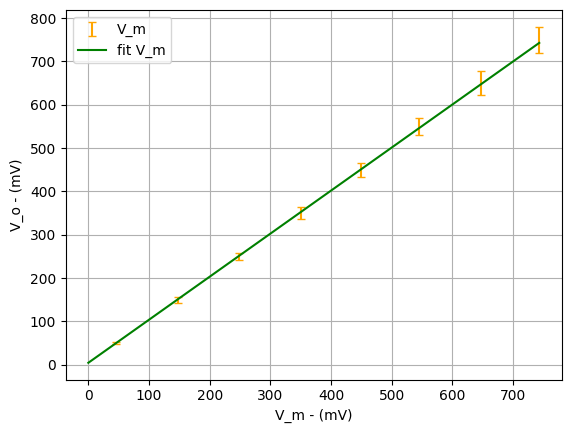

In [160]:
import numpy as np
from matplotlib import pyplot as plt  # this is the traditional method
from scipy.optimize import curve_fit  # import method used here

#we define the function for the linear fit
def linear_fit(x, a, b):
    return a + b*x

#we define a function to evaluate the measurement error of the oscilloscope, we use 1/2 as the factor for the appreciable lines.(except for sz which is calculated before with factor 1)
def oscilloscope_error(sz, f_s, measure):
    sl = f_s/10
    sc = measure*0.03
    return np.sqrt(sz**2 + sl**2 + sc**2)

#we calculated the error on zero as
s_z = 0.2 #(mV)

file_to_analyze = "Calibrazione"
Data = np.loadtxt("Dati/" + file_to_analyze, float, skiprows=1, comments= "#")
V_m = Data[:, 0]
V_o = Data[:, 1]
f_s_V_o = Data[:, 2]

#evaluate the error on the oscilloscope
error_V_o = oscilloscope_error(s_z, f_s_V_o, V_o)

# initial guess
a = 0
b = 1
initial_guess_cal = np.array([a,b])

#fit the data
fit_cal, cov_cal = curve_fit(linear_fit, V_m, V_o, sigma=error_V_o, p0=initial_guess_cal)

error_cal = np.sqrt(np.diag(cov_cal))

# print the results
print('a = ', '{:.3f}'.format(fit_cal[0]), '±', '{:.5f}'.format(error_cal[0]))
print('b = ', '{:.3f}'.format(fit_cal[1]), '±', '{:.5f}'.format(error_cal[1]))

#plot the fits
plt.xlabel("V_m - (mV)")
plt.ylabel("V_o - (mV)")

simul_V_m = np.linspace(0, V_m[len(V_m) - 1], 100)
simul_V_o = linear_fit(simul_V_m, fit_cal[0], fit_cal[1])

plt.errorbar(V_m, V_o, error_V_o, linestyle="none", color="orange", capsize=3, capthick=1, label="V_m") #data with error
plt.errorbar(simul_V_m, simul_V_o, label="fit V_m", color="green") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Calibrazione")
plt.show()

Osserviamo che la retta non intercetta l'origine, e ha la pendenza di poco diversa da 1. Per ottenere dei fit precisi dovrò adattare i dati misurati dall'oscilloscopio.

## Adattamento dati
Per adattare i dati dovrò passare dal potenziale misurati con l'oscilloscopio a quelli "veri" (Assumiamo che il multimetro dia valori affidabili) utilizzando i parametri ottenuti nel fit sopra:
$$
V_{vero} = \frac{V_{oscilloscopio} - a}{b}
$$
e calcoliamo l'errore come:
$$
\delta V_{vero} = \sqrt{ \frac{\delta a ^2}{b^2} + \frac{(V_0 -a)^2}{b^2} \delta b ^2 + b^2 \delta V_0 ^2 + 2 \delta ab}
$$

In [161]:
#We introduce 2 function that evaluate the "true" values
def recalibrate_V(a, b, V_0):
    return (V_0 - a)/b

def recalibrate_V_error(a, b, V_0, da, db, dV_0, dab):
    return np.sqrt((da/b)**2 + (db*(V_0 - a)/b)**2 + (b*dV_0)**2 + 2*dab)

## Caratteristica I-V
Vogliamo studiare le caratteristiche dei 2 diodi.
La caratteristica di un diodo è:
$$
I = I_{0}( \exp{\frac{V_D}{\eta V_T}} - 1 )
$$

In [162]:
def f_I(V_D, I_0, eta_V_T):
    return I_0*(np.exp(V_D/eta_V_T) - 1)

Per fare il fit quindi possiamo linearizzarla ed otteniamo:
$$
V_D = -\eta V_T \log{I_{0}} + \eta V_T \log{I}
$$

analogo a: $Y = a + bX$ con $a = -\eta V_T \log{I_{0}} $ e $b = \eta V_T $

Non è veramente preciso(funzione solo se I_0 molto piccolo).

La linearizzazione più precisa è:
$$
V_D = -\eta V_T \log{I_{0}} + \eta V_T \log{(I + I_0)}
$$

In [163]:
def f_V(I, I_0, eta_V_T):
    return eta_V_T*np.log((I + I_0)/I_0)

### Silicio
Facciamo il fit e calcoliamo i parametri

In [164]:
file_to_analyze = "Silicio"
Data = np.loadtxt("Dati/" + file_to_analyze, float, skiprows=1, comments= "#")
I_Si = Data[:, 0]
V_Si_osc = Data[:, 1]
f_s_Si = Data[:, 2] # it's the f.s of the oscilloscope

#evaluate the error
error_V_Si_osc = oscilloscope_error(s_z, f_s_Si, V_Si_osc)

#ricalibriamo i valori e gli errori di V
V_Si = recalibrate_V(fit_cal[0], fit_cal[1], V_Si_osc)
error_V_Si = recalibrate_V_error(fit_cal[0], fit_cal[1], V_Si_osc, error_cal[0], error_cal[1], error_V_Si_osc, cov_cal[0][1])

# initial guess
a_Si = 62
b_Si = 6
initial_guess_Si = np.array([a,b])

#fit the data
fit_Si, cov_Si = curve_fit(linear_fit, np.log(I_Si), V_Si, sigma=error_V_Si, p0=initial_guess_Si)

error_Si = np.sqrt(np.diag(cov_Si))

# print the fit results
print('a_Si = ', '{:.3f}'.format(fit_Si[0]), '±', '{:.5f}'.format(error_Si[0]))
print('b_Si = ', '{:.3f}'.format(fit_Si[1]), '±', '{:.5f}'.format(error_Si[1]))

# evaluate the reduced chi_square and R^2
residual_V_Si = V_Si - a_Si - b_Si * np.log(I_Si)
chisq_Si = sum((residual_V_Si / error_V_Si) ** 2)
degrees_of_freedom_Si = len(residual_V_Si) - 1
reduced_chisq_Si = chisq_Si / degrees_of_freedom_Si
R_2_Si = 1 - (sum(residual_V_Si ** 2) / sum((V_Si - sum(V_Si)/len(V_Si)) ** 2))

#print the reduced chisquared and R^2
print('reduced chi-squared = ', '{:.3f}'.format(reduced_chisq_Si))
print('R^2 = ', '{:.3f}'.format(R_2_Si))

a_Si =  62.014 ± 0.39284
b_Si =  6.462 ± 0.15266
reduced chi-squared =  0.527
R^2 =  0.987


Calcoliamo i parametri del diodo, coi relativi errori. In particolare l'errore su $I_0$ si calcola come:
$$
\delta I_0 = \frac{I_0}{b} \sqrt{(\delta a)^2 + \frac{a^2}{b^2} (\delta b)^2 + 2\frac{a}{b}\delta ab}
$$

In [165]:
#evaluate the results
eta_V_T_Si = fit_Si[1]
eta_V_T_error_Si = error_Si[1]
I_0_Si = np.exp(-fit_Si[0]/fit_Si[1])
I_0_error_Si = (I_0_Si/fit_Si[1])*np.sqrt(error_Si[0]**2 + ((a**2)/(b**2))*error_Si[1]**2 + 2*(fit_Si[0]/fit_Si[1])*cov_Si[0][1])

#print the results
print('eta V_T = ', '{:.3f}'.format(eta_V_T_Si), '±', '{:.5f}'.format(eta_V_T_error_Si))
print('I_0 = ', '{:.6f}'.format(I_0_Si), '±', '{:.9f}'.format(I_0_error_Si))

eta V_T =  6.462 ± 0.15266
I_0 =  0.000068 ± 0.000010994


Facciamo i grafici dei fit, sia quello esponenziale che quello in semiscala logaritmica

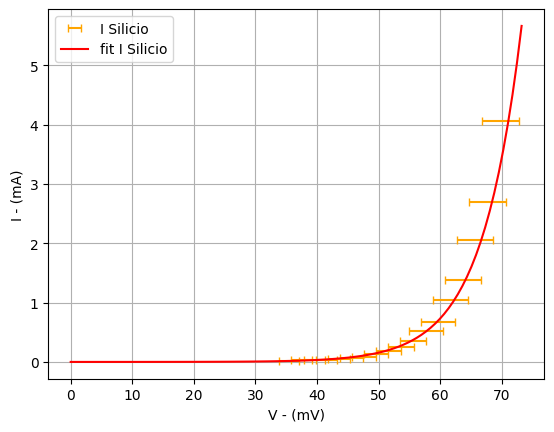

In [166]:
simul_V_Si = np.linspace(0.01, 1.05*V_Si[len(V_Si) - 1], 100)
simul_I_Si = f_I(simul_V_Si, I_0_Si, eta_V_T_Si)

#normal graph
plt.xlabel("V - (mV)")
plt.ylabel("I - (mA)")

plt.errorbar(V_Si, I_Si, xerr = error_V_Si, linestyle="none", color="orange", capsize=3, capthick=1, label="I Silicio") # data with error
plt.errorbar(simul_V_Si, simul_I_Si, label="fit I Silicio", color="red") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Caratteristica_Si")
plt.show()

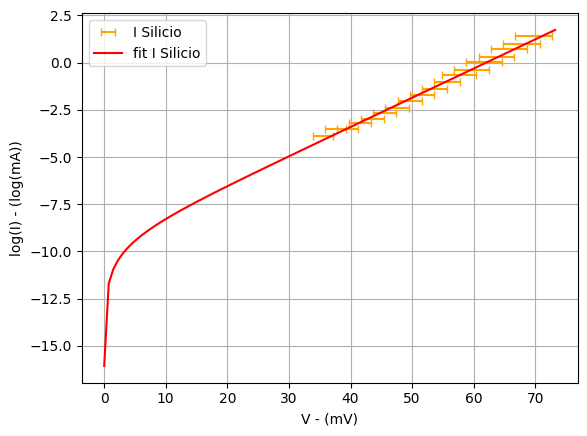

In [167]:
#semilogarithmic graph
plt.xlabel("V - (mV)")
plt.ylabel("log(I) - (log(mA))")

plt.errorbar(V_Si, np.log(I_Si), xerr = error_V_Si, linestyle="none", color="orange", capsize=3, capthick=1, label="I Silicio") # data with error
plt.errorbar(simul_V_Si, np.log(simul_I_Si), label="fit I Silicio", color="red") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Caratteristica_Si(semilog)")
plt.show()

### Germanio
Analogamente come abbiamo fatto come con il silicio

In [168]:
file_to_analyze = "Germanio"
Data = np.loadtxt("Dati/" + file_to_analyze, float, skiprows=1, comments= "#")
I_Ge = Data[:, 0]
V_Ge_osc = Data[:, 1]
f_s_Ge = Data[:, 2] # it's the error on the V

#evaluate the error
error_V_Ge_osc = oscilloscope_error(s_z, f_s_Ge, V_Ge_osc)

#recalibrate
V_Ge = recalibrate_V(fit_cal[0], fit_cal[1], V_Ge_osc)
error_V_Ge = recalibrate_V_error(fit_cal[0], fit_cal[1], V_Ge_osc, error_cal[0], error_cal[1], error_V_Ge_osc, cov_cal[0][1])

# initial guess
a_Ge = 23
b_Ge = 6
initial_guess_Ge = np.array([a,b])

#fit the data
fit_Ge, cov_Ge = curve_fit(linear_fit, np.log(I_Ge), V_Ge, sigma=error_V_Ge, p0=initial_guess_Ge)

error_Ge = np.sqrt(np.diag(cov_Ge))

# print the fit results
print('a_Ge = ', '{:.3f}'.format(fit_Ge[0]), '±', '{:.5f}'.format(error_Ge[0]))
print('b_Ge = ', '{:.3f}'.format(fit_Ge[1]), '±', '{:.5f}'.format(error_Ge[1]))

# evaluate the reduced chi_square and R^2
residual_V_Ge = V_Ge - a_Ge - b_Ge * np.log(I_Ge)
chisq_Ge = sum((residual_V_Ge / error_V_Ge) ** 2)
degrees_of_freedom_Ge = len(residual_V_Ge) - 1
reduced_chisq_Ge = chisq_Ge / degrees_of_freedom_Ge
R_2_Ge = 1 - (sum(residual_V_Ge ** 2) / sum((V_Ge - sum(V_Ge)/len(V_Ge)) ** 2))

#print the reduced chisquared and R^2
print('reduced chi-squared = ', '{:.3f}'.format(reduced_chisq_Ge))
print('R^2 = ', '{:.3f}'.format(R_2_Ge))

a_Ge =  23.424 ± 0.15961
b_Ge =  5.746 ± 0.06708
reduced chi-squared =  1.263
R^2 =  0.991


Calcoliamo i parametri

In [169]:
#evaluate the results
eta_V_T_Ge = fit_Ge[1]
eta_V_T_error_Ge = error_Ge[1]
I_0_Ge = np.exp(-fit_Ge[0]/fit_Ge[1])
I_0_error_Ge = (I_0_Si/fit_Ge[1])*np.sqrt(error_Ge[0]**2 + ((a**2)/(b**2))*error_Ge[1]**2 + 2*(fit_Ge[0]/fit_Ge[1])*cov_Ge[0][1])

#print the results
print('eta V_T = ', '{:.3f}'.format(eta_V_T_Ge), '±', '{:.5f}'.format(eta_V_T_error_Ge))
print('I_0 = ', '{:.6f}'.format(I_0_Ge), '±', '{:.9f}'.format(I_0_error_Ge))

eta V_T =  5.746 ± 0.06708
I_0 =  0.016967 ± 0.000003585


Facciamo i grafici dei fit, sia quello esponenziale che quello in semiscala logaritmica

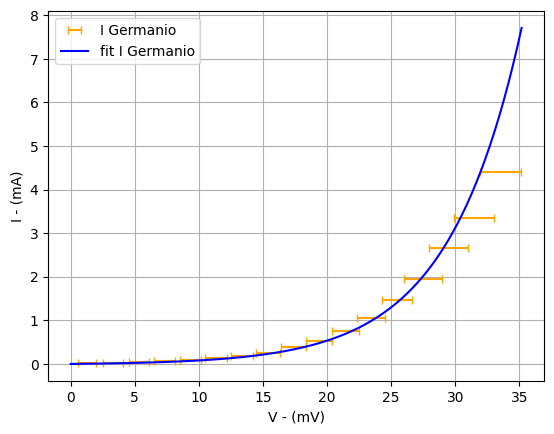

In [170]:
simul_V_Ge = np.linspace(0.01, 1.05*V_Ge[len(V_Ge) - 1], 100)
simul_I_Ge = f_I(simul_V_Ge, I_0_Ge, eta_V_T_Ge)

#normal graph
plt.xlabel("V - (mV)")
plt.ylabel("I - (mA)")

plt.errorbar(V_Ge, I_Ge, xerr = error_V_Ge, linestyle="none", color="orange", capsize=3, capthick=1, label="I Germanio") # data with error
plt.errorbar(simul_V_Ge, simul_I_Ge, label="fit I Germanio", color="blue") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Caratteristica_Ge")
plt.show()

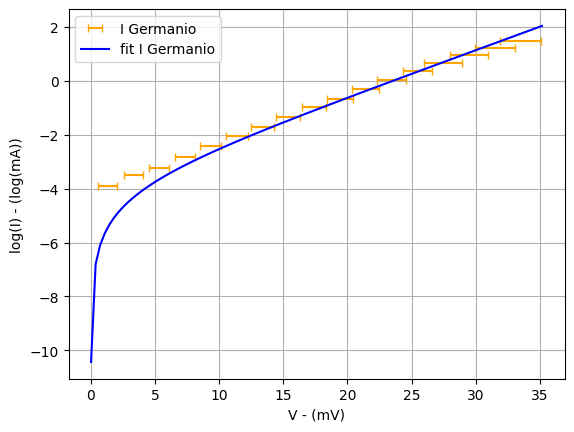

In [171]:
#semilogarithmic graph
plt.xlabel("V - (mV)")
plt.ylabel("log(I) - (log(mA))")

plt.errorbar(V_Ge, np.log(I_Ge), xerr = error_V_Ge, linestyle="none", color="orange", capsize=3, capthick=1, label="I Germanio") # data with error
plt.errorbar(simul_V_Ge, np.log(simul_I_Ge), label="fit I Germanio", color="blue") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Caratteristica_Ge(semilog)")
plt.show()

### Confronto caratteristiche
Confrontiamo i grafici delle caratteristiche dei 2 diodi

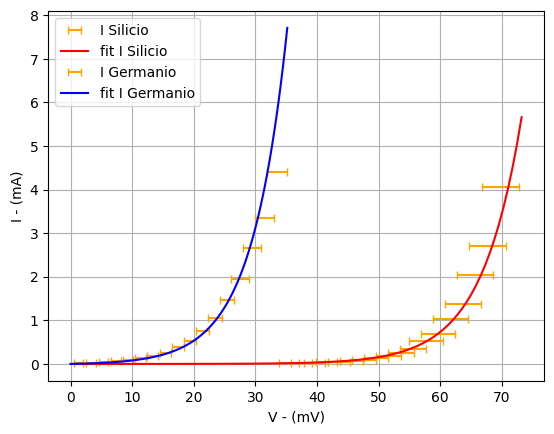

In [172]:
plt.xlabel("V - (mV)")
plt.ylabel("I - (mA)")

plt.errorbar(V_Si, I_Si, xerr = error_V_Si, linestyle="none", color="orange", capsize=3, capthick=1, label="I Silicio") # data with error
plt.errorbar(simul_V_Si, simul_I_Si, label="fit I Silicio", color="red") #fit


plt.errorbar(V_Ge, I_Ge, xerr = error_V_Ge, linestyle="none", color="orange", capsize=3, capthick=1, label="I Germanio") # data with error
plt.errorbar(simul_V_Ge, simul_I_Ge, label="fit I Germanio", color="blue") #fit


plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Confronto")
plt.show()

## Fit più preciso

Facciamo il fit utilizzando l'espressione più precisa:
$$
V_D = -\eta V_T \log{I_{0}} + \eta V_T \log{(I + I_0)}
$$

In [173]:
# bounds
Si_bounds = [[0.000001, 1], [0.1, 10]]
Ge_Bounds = [[0.001, 1], [0.1, 10]]

#fit the data
fit_Si_pr, cov_Si_pr = curve_fit(f_V, I_Si, V_Si, sigma=error_V_Si, bounds= Si_bounds)
fit_Ge_pr, cov_Ge_pr = curve_fit(f_V, I_Ge, V_Ge, sigma=error_V_Ge, bounds=Ge_Bounds)

error_Si_pr = np.sqrt(np.diag(cov_Si_pr))
error_Ge_pr = np.sqrt(np.diag(cov_Ge_pr))

#evaluate the chi squared and R^2
residual_V_Si_pr = V_Si - f_V(I_Si, fit_Si_pr[0], fit_Si_pr[1])
chisq_Si_pr = sum((residual_V_Si_pr / error_V_Si) ** 2)
degrees_of_freedom_Si_pr = len(residual_V_Si_pr) - 1
reduced_chisq_Si_pr = chisq_Si_pr / degrees_of_freedom_Si_pr
R_2_Si_pr = 1 - (sum(residual_V_Si_pr ** 2) / sum((V_Si - sum(V_Si)/len(V_Si)) ** 2))

residual_V_Ge_pr = V_Ge - f_V(I_Ge, fit_Ge_pr[0], fit_Ge_pr[1])
chisq_Ge_pr = sum((residual_V_Ge_pr / error_V_Ge) ** 2)
degrees_of_freedom_Ge_pr = len(residual_V_Ge_pr) - 1
reduced_chisq_Ge_pr = chisq_Ge_pr / degrees_of_freedom_Ge_pr
R_2_Ge_pr = 1 - (sum(residual_V_Ge_pr ** 2) / sum((V_Ge - sum(V_Ge)/len(V_Ge)) ** 2))

# print the fit results
print("Silicio")
print('I_0 = ', '{:.6f}'.format(fit_Si_pr[0]), '±', '{:.6f}'.format(error_Si_pr[0]))
print('eta V_T = ', '{:.3f}'.format(fit_Si_pr[1]), '±', '{:.5f}'.format(error_Si_pr[1]))
print('reduced chi-squared = ', '{:.3f}'.format(reduced_chisq_Si_pr))
print('R^2 = ', '{:.3f}'.format(R_2_Si_pr))
print("Germanio")
print('I_0 = ', '{:.3f}'.format(fit_Ge_pr[0]), '±', '{:.5f}'.format(error_Ge_pr[0]))
print('eta V_T = ', '{:.3f}'.format(fit_Ge_pr[1]), '±', '{:.5f}'.format(error_Ge_pr[1]))
print('reduced chi-squared = ', '{:.3f}'.format(reduced_chisq_Ge_pr))
print('R^2 = ', '{:.3f}'.format(R_2_Ge_pr))

Silicio
I_0 =  0.000068 ± 0.000012
eta V_T =  6.465 ± 0.15395
reduced chi-squared =  0.198
R^2 =  0.993
Germanio
I_0 =  0.034 ± 0.00373
eta V_T =  6.857 ± 0.25291
reduced chi-squared =  0.701
R^2 =  0.996


### Grafici
#### Silicio

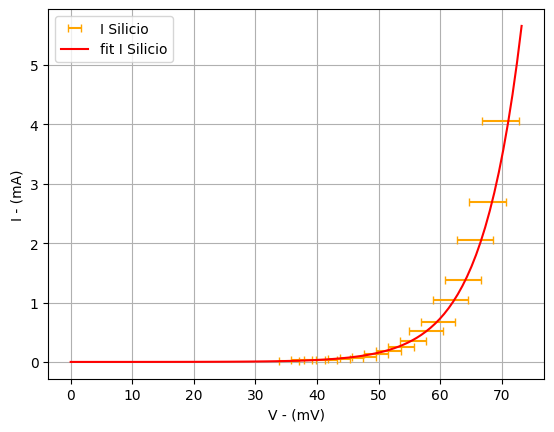

In [174]:
simul_I_Si = f_I(simul_V_Si, fit_Si_pr[0], fit_Si_pr[1])

#normal graph
plt.xlabel("V - (mV)")
plt.ylabel("I - (mA)")

plt.errorbar(V_Si, I_Si, xerr = error_V_Si, linestyle="none", color="orange", capsize=3, capthick=1, label="I Silicio") # data with error
plt.errorbar(simul_V_Si, simul_I_Si, label="fit I Silicio", color="red") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Caratteristica_Si_pr")
plt.show()

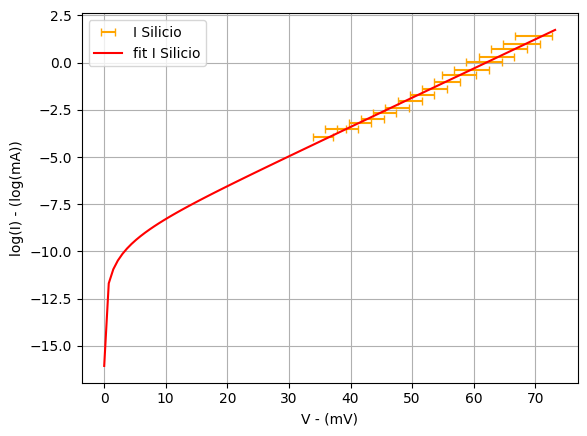

In [175]:
#semilogarithmic graph
plt.xlabel("V - (mV)")
plt.ylabel("log(I) - (log(mA))")

plt.errorbar(V_Si, np.log(I_Si), xerr = error_V_Si, linestyle="none", color="orange", capsize=3, capthick=1, label="I Silicio") # data with error
plt.errorbar(simul_V_Si, np.log(simul_I_Si), label="fit I Silicio", color="red") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Caratteristica_Si_pr(semilog)")
plt.show()

#### Germanio

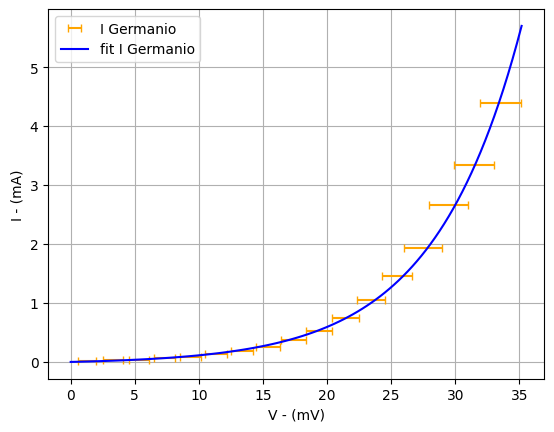

In [176]:
simul_I_Ge = f_I(simul_V_Ge, fit_Ge_pr[0], fit_Ge_pr[1])

#normal graph
plt.xlabel("V - (mV)")
plt.ylabel("I - (mA)")

plt.errorbar(V_Ge, I_Ge, xerr = error_V_Ge, linestyle="none", color="orange", capsize=3, capthick=1, label="I Germanio") # data with error
plt.errorbar(simul_V_Ge, simul_I_Ge, label="fit I Germanio", color="blue") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Caratteristica_Ge_pr")
plt.show()

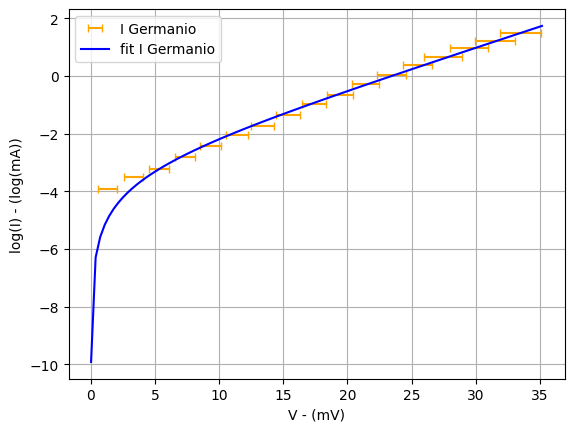

In [177]:
#semilogarithmic graph
plt.xlabel("V - (mV)")
plt.ylabel("log(I) - (log(mA))")

plt.errorbar(V_Ge, np.log(I_Ge), xerr = error_V_Ge, linestyle="none", color="orange", capsize=3, capthick=1, label="I Germanio") # data with error
plt.errorbar(simul_V_Ge, np.log(simul_I_Ge), label="fit I Germanio", color="blue") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.savefig("Out/Caratteristica_Ge_pr(semilog)")
plt.show()